# Bài tập cuối kỳ môn Machine Learning: Dự đoán xem một nhân viên sẽ nghỉ việc hay không

## Thư viện

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Define các hàm để in ra sự so sánh (nếu có)

In [31]:
def visualize_metrics(metrics):

    # List of classifiers and metrics
    classifiers = list(metrics.keys())
    metric_names = list(metrics[classifiers[0]].keys())


    bar_width = 0.15  # Set the width of the bars
    padding = 0.05  # Adjust the padding value as desired

    # Set the positions of the x-axis ticks
    x_pos = np.arange(len(classifiers))

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the bar chart size

    # Plot each metric as a group of bars
    for i, metric in enumerate(metric_names):
        metric_values = [metrics[classifier][metric] for classifier in classifiers]
        bar_positions = x_pos + ((bar_width + padding) * i)
        ax.bar(bar_positions, metric_values, bar_width, label=metric)

    # Set the labels and title
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x_pos + (((bar_width + padding) * (len(metric_names) - 1)) / 2))
    ax.set_xticklabels(classifiers)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.tight_layout()
    plt.show()




def print_metrics(accuracy, precision, recall, f1):
        print("Accuracy: {:.4f}".format(accuracy))
        print("Precision: {:.4f}".format(precision))
        print("Recall: {:.4f}".format(recall))
        print("F1-Score: {:.4f}".format(f1))

def plot_loss_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



## Phần 1 + Phần 4: Data Exploration + Data Preprocessing + Using Feature Selection for Reducing Overfitting

### Data cleaning

In [32]:
df = pd.DataFrame(pd.read_csv('Employee.csv'))
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [33]:
df.isna().sum()

# Không có giá trị null trong tập dữ liệu nên không cần xử lý "Missing Values"

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [34]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Xử lý dữ liệu trùng lặp.

### Data handling Categorical và Transformation


In [35]:
df['Education'].unique()


array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [36]:
df['City'].unique()

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [37]:
df['PaymentTier'].unique()

array([3, 1, 2])

In [38]:
# Có 3 features thuộc dạng categorical nên cần phải chuyển đổi

df_dummies = pd.get_dummies(df, columns=['JoiningYear', 'Education', 'City', 'PaymentTier'])
df_dummies

,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,...,JoiningYear_2018,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
0,34,Male,No,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,28,Female,No,3,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,38,Female,No,2,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,27,Male,No,5,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
4,24,Male,Yes,2,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,Female,No,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4647,30,Male,No,2,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
4649,37,Male,No,2,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4650,27,Male,No,5,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1


In [39]:
df_dummies.dtypes

Age                           int64
Gender                       object
EverBenched                  object
ExperienceInCurrentDomain     int64
LeaveOrNot                    int64
JoiningYear_2012              uint8
JoiningYear_2013              uint8
JoiningYear_2014              uint8
JoiningYear_2015              uint8
JoiningYear_2016              uint8
JoiningYear_2017              uint8
JoiningYear_2018              uint8
Education_Bachelors           uint8
Education_Masters             uint8
Education_PHD                 uint8
City_Bangalore                uint8
City_New Delhi                uint8
City_Pune                     uint8
PaymentTier_1                 uint8
PaymentTier_2                 uint8
PaymentTier_3                 uint8
dtype: object

In [40]:
le = LabelEncoder()

name = list(df_dummies.columns)
type = df_dummies.dtypes

for i in range(len(type)):
    if type[i] == 'object' or type[i] == 'bool':
        le.fit_transform(df_dummies[name[i]])
        df_dummies[name[i]] = le.transform(df_dummies[name[i]])

df_dummies

,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,...,JoiningYear_2018,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
0,34,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,28,0,0,3,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,38,0,0,2,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,27,1,0,5,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
4,24,1,1,2,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4647,30,1,0,2,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
4649,37,1,0,2,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4650,27,1,0,5,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1


### Data Exploration

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'EverBenched'}>,
        <Axes: title={'center': 'ExperienceInCurrentDomain'}>,
        <Axes: title={'center': 'LeaveOrNot'}>],
       [<Axes: title={'center': 'JoiningYear_2012'}>,
        <Axes: title={'center': 'JoiningYear_2013'}>,
        <Axes: title={'center': 'JoiningYear_2014'}>,
        <Axes: title={'center': 'JoiningYear_2015'}>,
        <Axes: title={'center': 'JoiningYear_2016'}>],
       [<Axes: title={'center': 'JoiningYear_2017'}>,
        <Axes: title={'center': 'JoiningYear_2018'}>,
        <Axes: title={'center': 'Education_Bachelors'}>,
        <Axes: title={'center': 'Education_Masters'}>,
        <Axes: title={'center': 'Education_PHD'}>],
       [<Axes: title={'center': 'City_Bangalore'}>,
        <Axes: title={'center': 'City_New Delhi'}>,
        <Axes: title={'center': 'City_Pune'}>,
        <Axes: title={'center': 'PaymentTier_1'}>,
        <

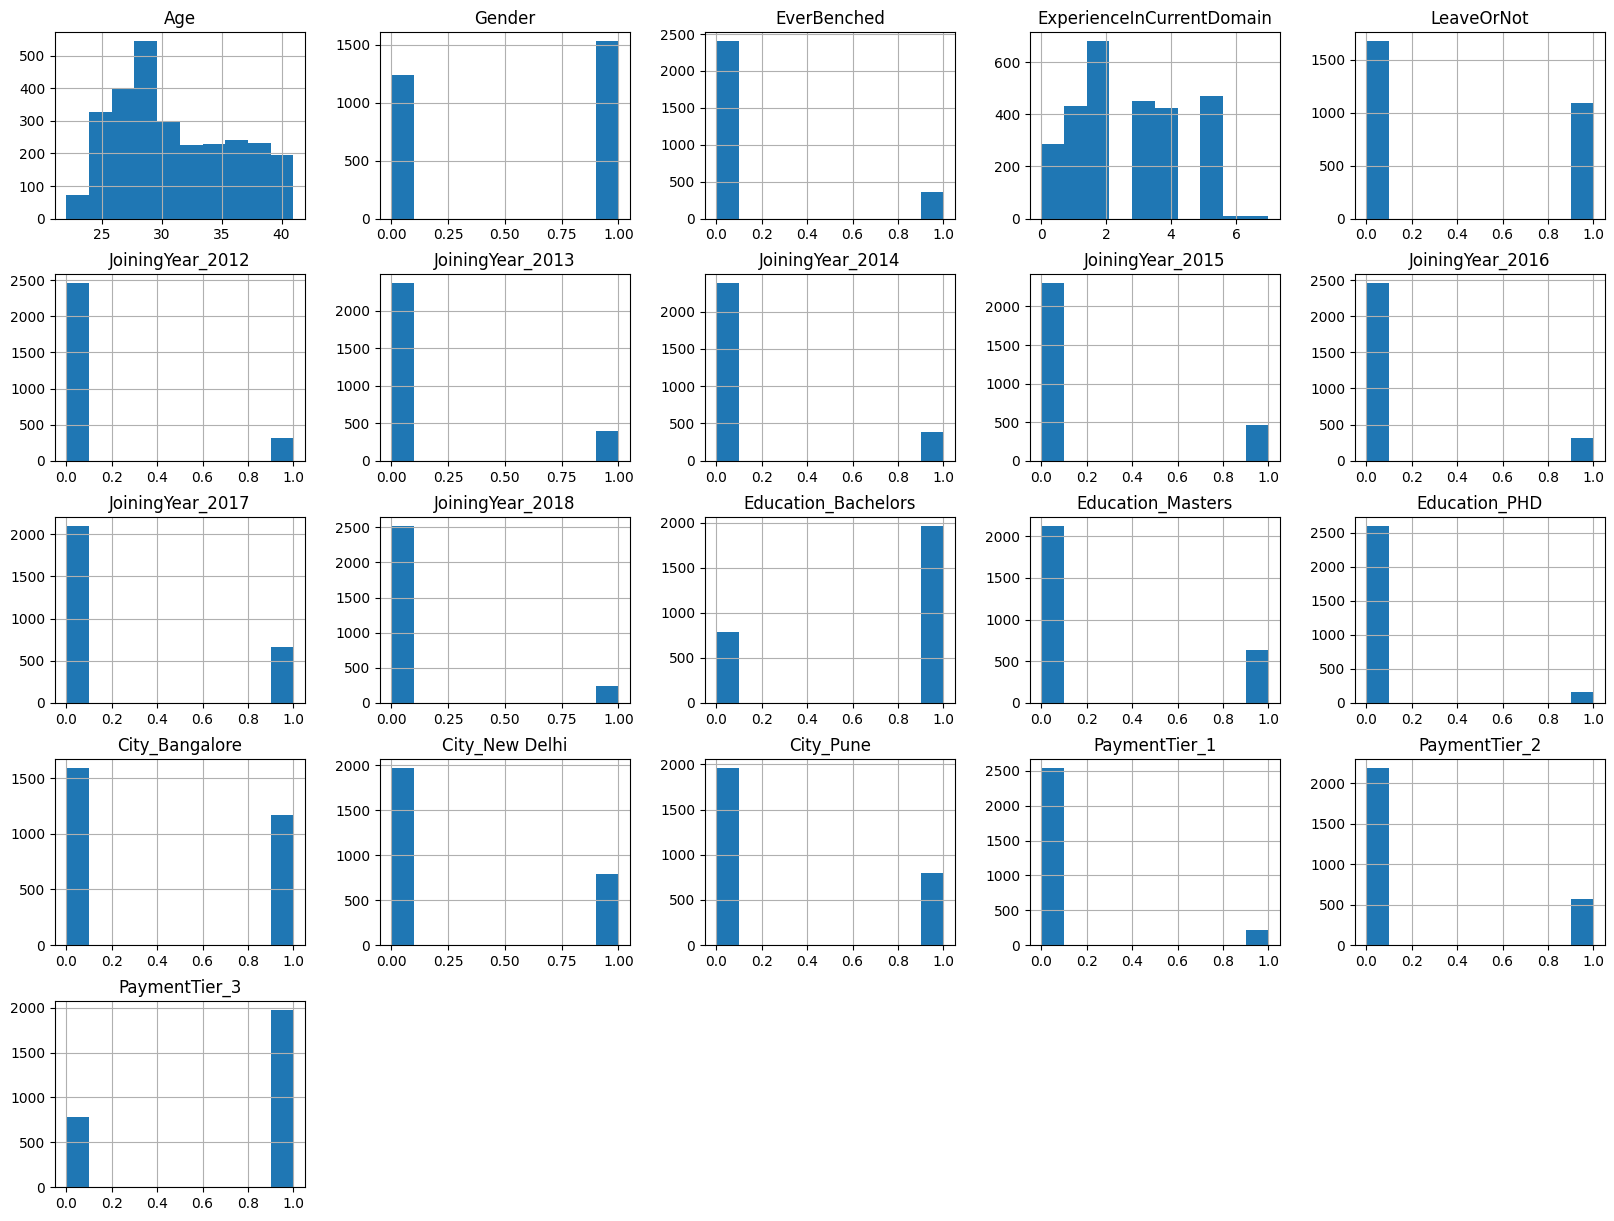

In [41]:
df_dummies.hist(figsize=(20, 15))

C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\385756184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

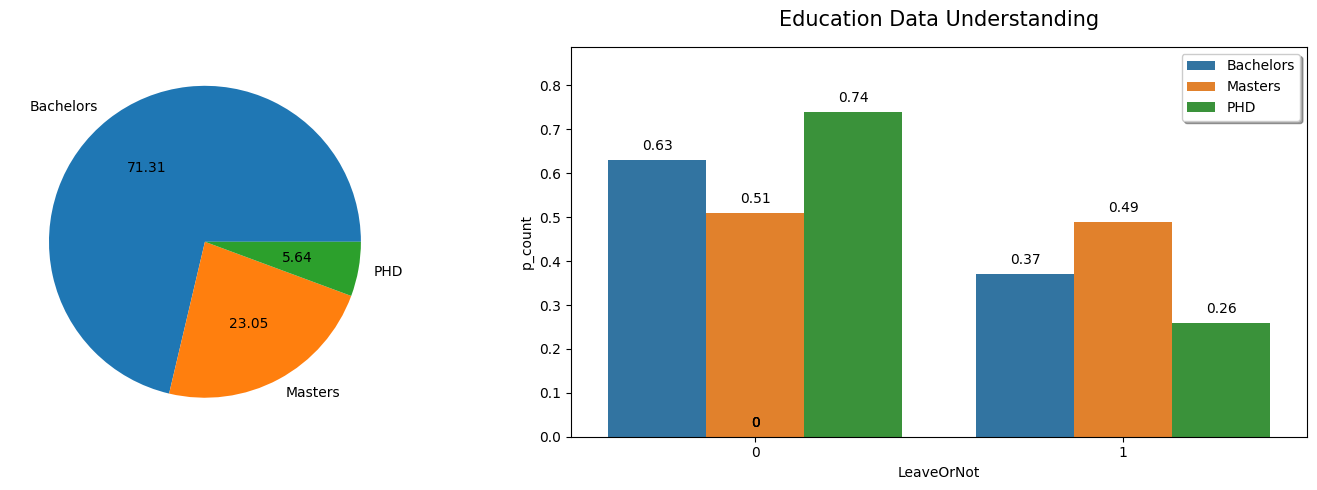

In [139]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên trình độ học vấn

data1=df.Education.value_counts().reset_index()
data2=df.groupby(['Education','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Education.unique():
    msg=data2[data2.Education==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Education'], autopct='%.2f')
ax[1].set_title('Education Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Education', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\3541328264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

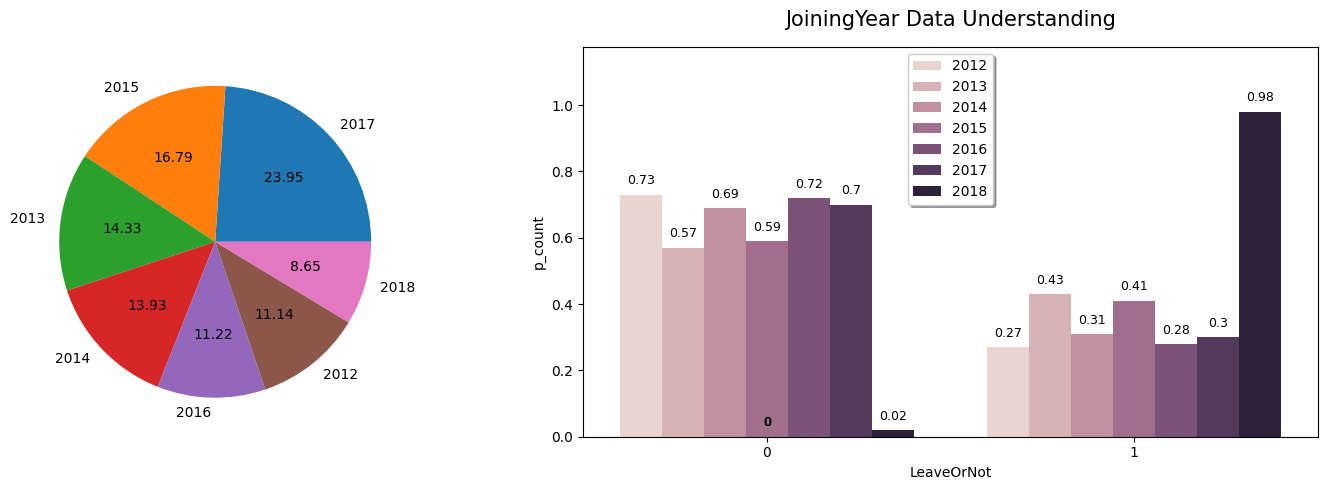

In [140]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên năm ứng tuyển

data1=df.JoiningYear.value_counts().reset_index()
data2=df.groupby(['JoiningYear','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.JoiningYear.unique():
    msg=data2[data2.JoiningYear==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['JoiningYear'], autopct='%.2f')
ax[1].set_title('JoiningYear Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='JoiningYear', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\628811176.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

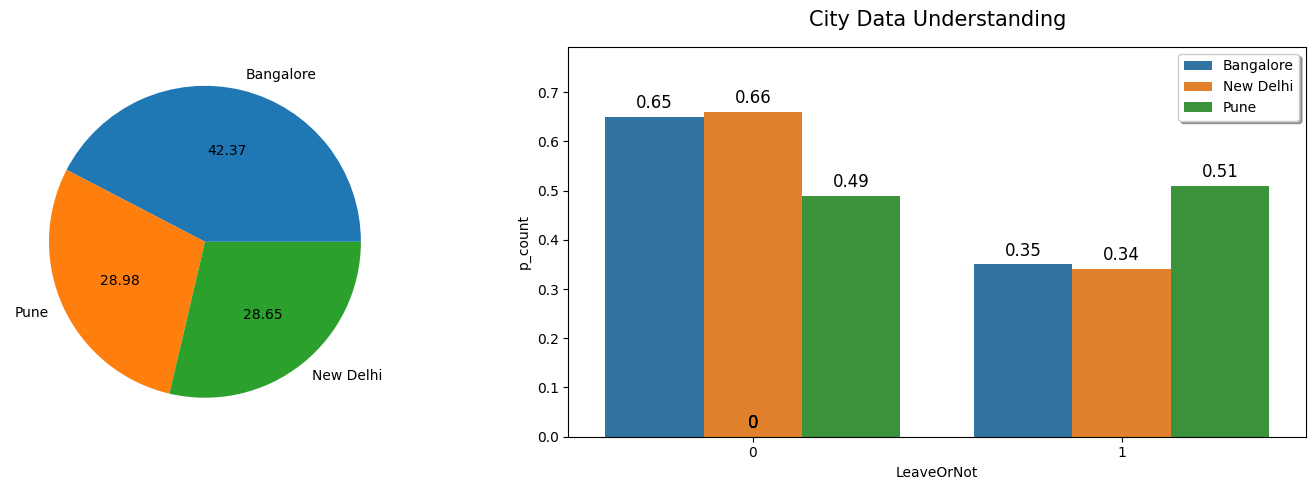

In [141]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên thành phố sinh sống

data1=df.City.value_counts().reset_index()
data2=df.groupby(['City','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.City.unique():
    msg=data2[data2.City==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['City'], autopct='%.2f')
ax[1].set_title('City Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='City', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\1634165482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


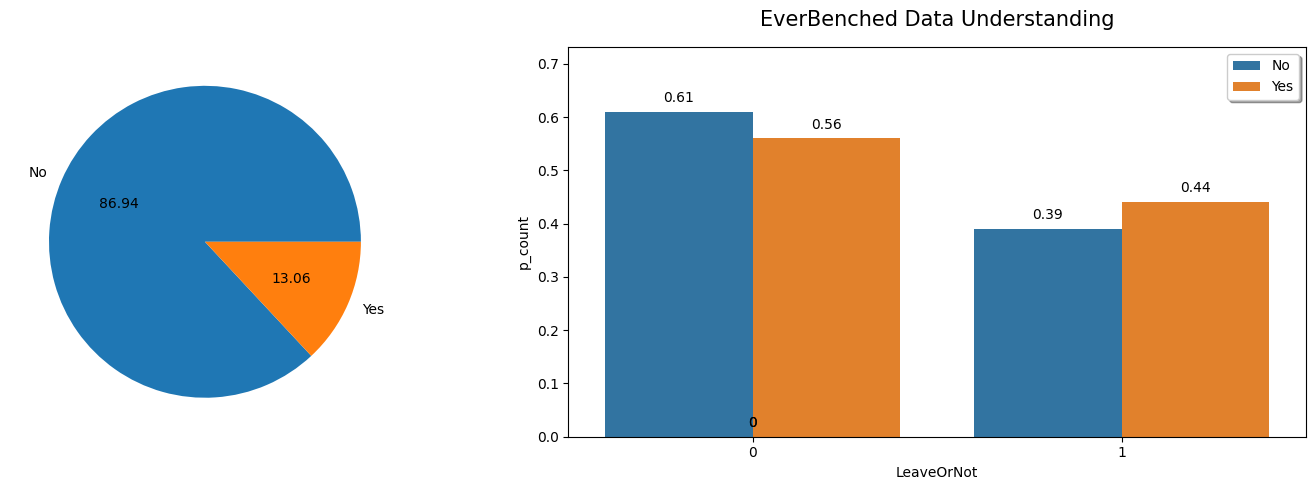

In [142]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên lịch sử thăng cấp

data1=df.EverBenched.value_counts().reset_index()
data2=df.groupby(['EverBenched','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.EverBenched.unique():
    msg=data2[data2.EverBenched==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['EverBenched'], autopct='%.2f')
ax[1].set_title('EverBenched Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='EverBenched', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\tqbao\AppData\Local\Temp\ipykernel_24276\268465423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


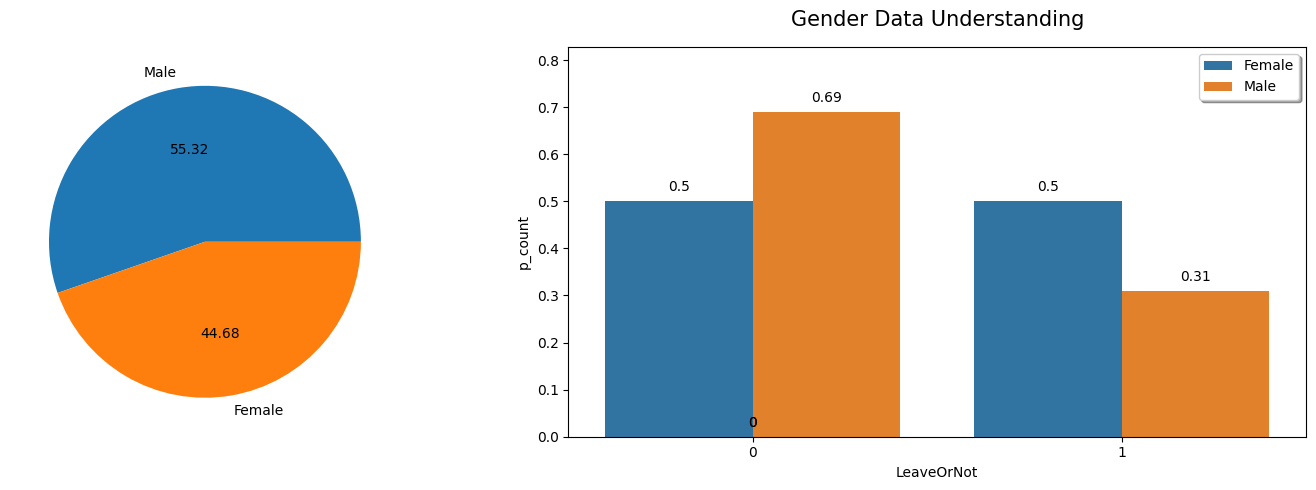

In [143]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên giới tính

data1=df.Gender.value_counts().reset_index()
data2=df.groupby(['Gender','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Gender.unique():
    msg=data2[data2.Gender==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Gender'], autopct='%.2f')
ax[1].set_title('Gender Data Understanding', fontsize=15, pad=15)

# Bar plot
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Gender', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

### Sử dụng Pearson Corelation để xem điểm tương quang giữa các Feature

<Axes: >

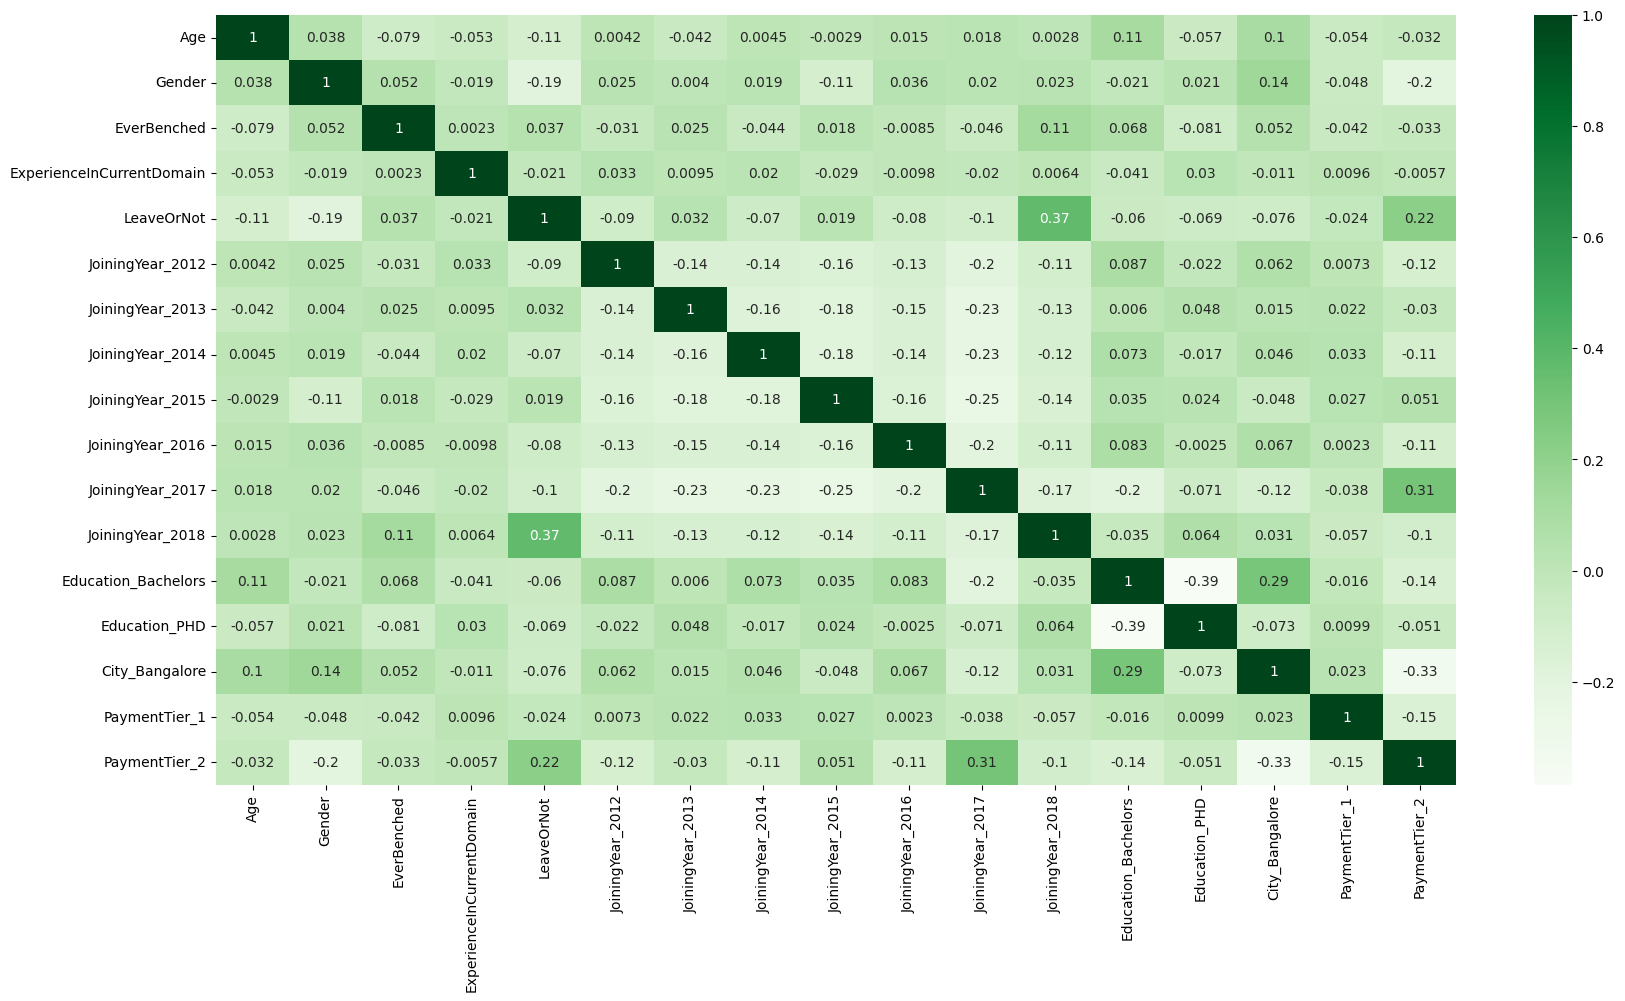

In [144]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap="Greens")

In [145]:
# # từ bản tương quan có thể thấy rằng bằng thạc sĩ hoặc cử nhân có tương quang tương đương nhau nên có thểm drop 1 trong 2
corr_matrix = df_dummies.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
to_drop.remove("LeaveOrNot") if "LeaveOrNot" in to_drop else None
df_dummies.drop(to_drop, axis=1, inplace=True)

<Axes: >

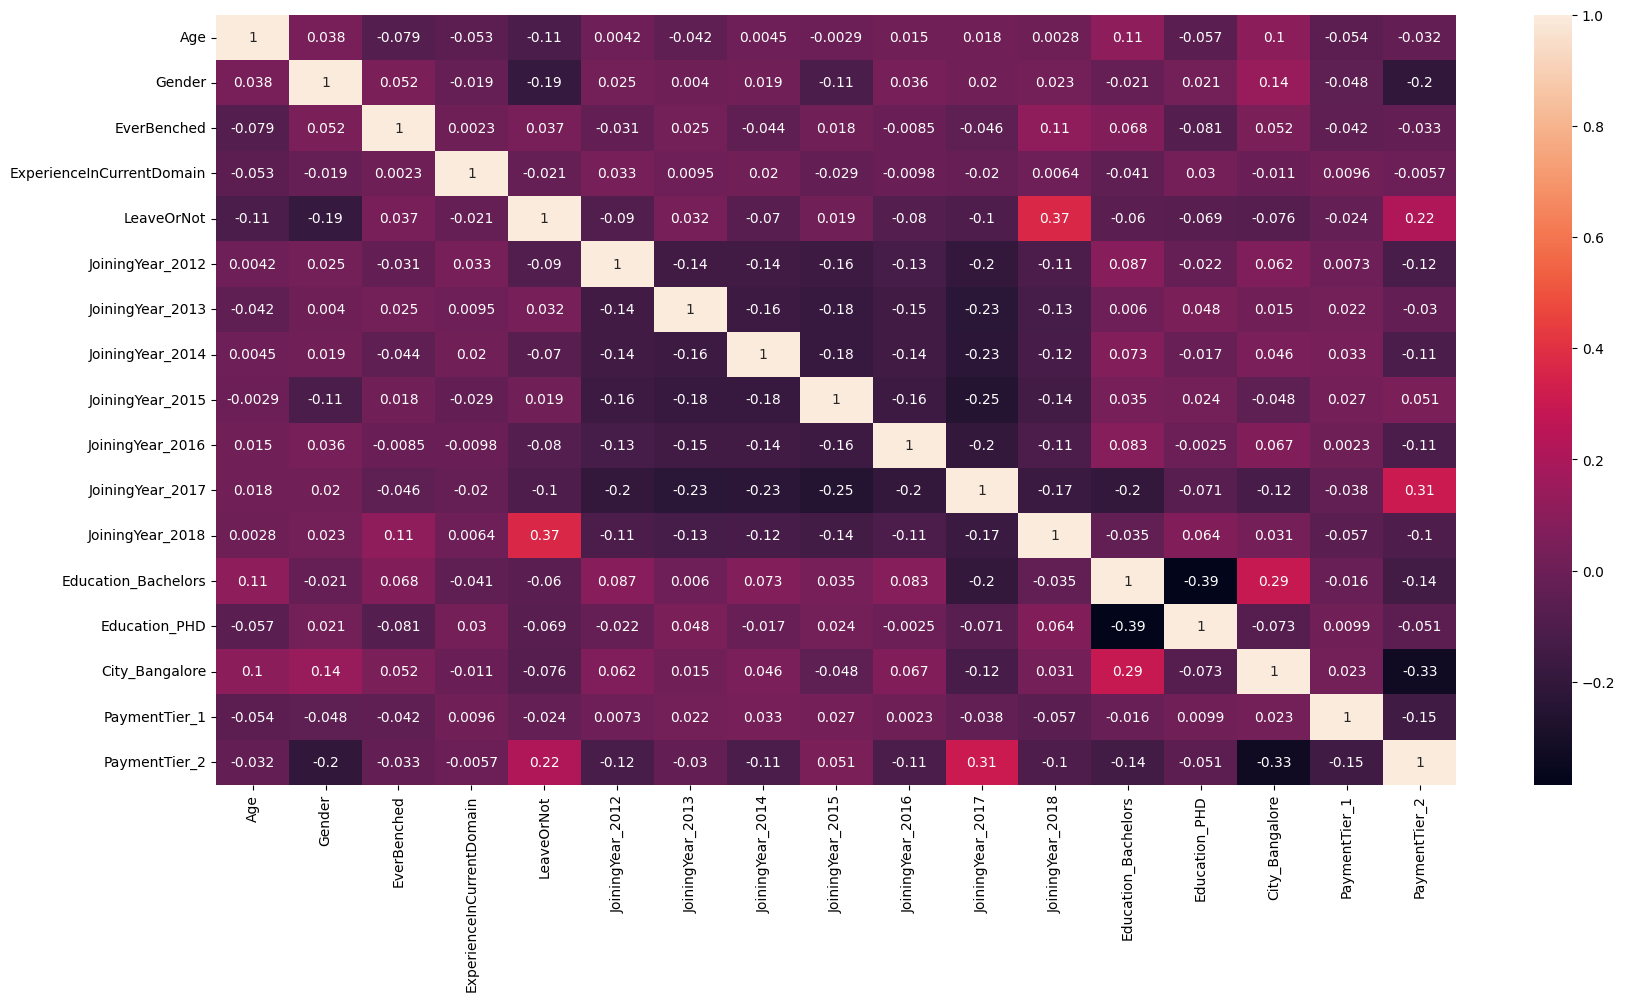

In [146]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True)

#### Regularization

In [43]:
X = df_dummies.drop('LeaveOrNot', axis=1)
y = df_dummies['LeaveOrNot']

In [44]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

In [45]:
X_scaled


array([[ 0.59652788,  0.89873103, -0.38759371, ..., -0.29261666,
        -0.50970526,  0.6314946 ],
       [-0.57811215, -1.11267995, -0.38759371, ...,  3.41744043,
        -0.50970526, -1.58354483],
       [ 1.37962124, -1.11267995, -0.38759371, ..., -0.29261666,
        -0.50970526,  0.6314946 ],
       ...,
       [ 1.1838479 ,  0.89873103, -0.38759371, ..., -0.29261666,
         1.96191814, -1.58354483],
       [-0.77388549,  0.89873103, -0.38759371, ..., -0.29261666,
        -0.50970526,  0.6314946 ],
       [-0.18656548,  0.89873103,  2.58002126, ..., -0.29261666,
        -0.50970526,  0.6314946 ]])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=5, test_size=0.3)

## Phần 2: Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing

### Các mô hình học máy cơ bản

#### KNN

#### Linear Regression

#### Decision Tree

#### Naive Bayes

#### SVM

#### Logistic Regression

### Ứng dụng các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

gb_accuracy = accuracy_score(y_test, y_test_pred)
gb_precision = precision_score(y_test, y_test_pred)
gb_recall = recall_score(y_test, y_test_pred)
gb_f1 = f1_score(y_test, y_test_pred)

print_metrics(gb_accuracy, gb_precision, gb_recall, gb_f1)

gb_train_before = accuracy_score(y_train, y_train_pred)
gb_test_before = gb_accuracy




Accuracy: 0.7867
Precision: 0.7937
Recall: 0.6154
F1-Score: 0.6932


#### AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_accuracy = accuracy_score(y_test, y_test_pred)
ada_precision = precision_score(y_test, y_test_pred)
ada_recall = recall_score(y_test, y_test_pred)
ada_f1 = f1_score(y_test, y_test_pred)

print_metrics(ada_accuracy, ada_precision, ada_recall, ada_f1)

ada_train_before = accuracy_score(y_train, y_train_pred)
ada_test_before = ada_accuracy



Accuracy: 0.7337
Precision: 0.7047
Recall: 0.5508
F1-Score: 0.6183


#### Bagging

In [49]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier()

bagging_clf.fit(X_train, y_train)

y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_test_pred)
bagging_precision = precision_score(y_test, y_test_pred)
bagging_recall = recall_score(y_test, y_test_pred)
bagging_f1 = f1_score(y_test, y_test_pred)

print_metrics(bagging_accuracy, bagging_precision, bagging_recall, bagging_f1)

bagging_train_before = accuracy_score(y_train, y_train_pred)
bagging_test_before = bagging_accuracy





Accuracy: 0.7229
Precision: 0.6578
Recall: 0.6092
F1-Score: 0.6326


#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_test_pred)
rf_precision = precision_score(y_test, y_test_pred)
rf_recall = recall_score(y_test, y_test_pred)
rf_f1 = f1_score(y_test, y_test_pred)

print_metrics(rf_accuracy, rf_precision, rf_recall, rf_f1)

rf_train_before = accuracy_score(y_train, y_train_pred)
rf_test_before = rf_accuracy



Accuracy: 0.7265
Precision: 0.6591
Recall: 0.6246
F1-Score: 0.6414


#### Voting Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Create individual classifiers
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)]
)

voting_clf.fit(X_train, y_train)
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

voting_accuracy = accuracy_score(y_test, y_test_pred)
voting_precision = precision_score(y_test, y_test_pred)
voting_recall = recall_score(y_test, y_test_pred)
voting_f1 = f1_score(y_test, y_test_pred)

print_metrics(voting_accuracy, voting_precision, voting_recall, voting_f1)

voting_train_before = accuracy_score(y_train, y_train_pred)
voting_test_before = voting_accuracy


Accuracy: 0.7783
Precision: 0.7765
Recall: 0.6092
F1-Score: 0.6828


#### Stacking

In [52]:
from sklearn.ensemble import StackingClassifier


stacking_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    final_estimator=lr_clf
)
stacking_clf.fit(X_train, y_train)
y_train_pred = stacking_clf.predict(X_train)
y_test_pred = stacking_clf.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_test_pred)
stacking_precision = precision_score(y_test, y_test_pred)
stacking_recall = recall_score(y_test, y_test_pred)
stacking_f1 = f1_score(y_test, y_test_pred)

print_metrics(stacking_accuracy, stacking_precision, stacking_recall, stacking_f1)

stacking_train_before = accuracy_score(y_train, y_train_pred)
stacking_test_before = stacking_accuracy



Accuracy: 0.7795
Precision: 0.7669
Recall: 0.6277
F1-Score: 0.6904


#### Hàm visualize_metrics sử dụng để so sánh hiệu suất của nhiều bộ phân loại (classifiers) khác nhau dựa trên các độ đo đánh giá như accuracy (độ chính xác), precision (độ chính xác dương tính), recall (độ phục hồi), và F1-score.

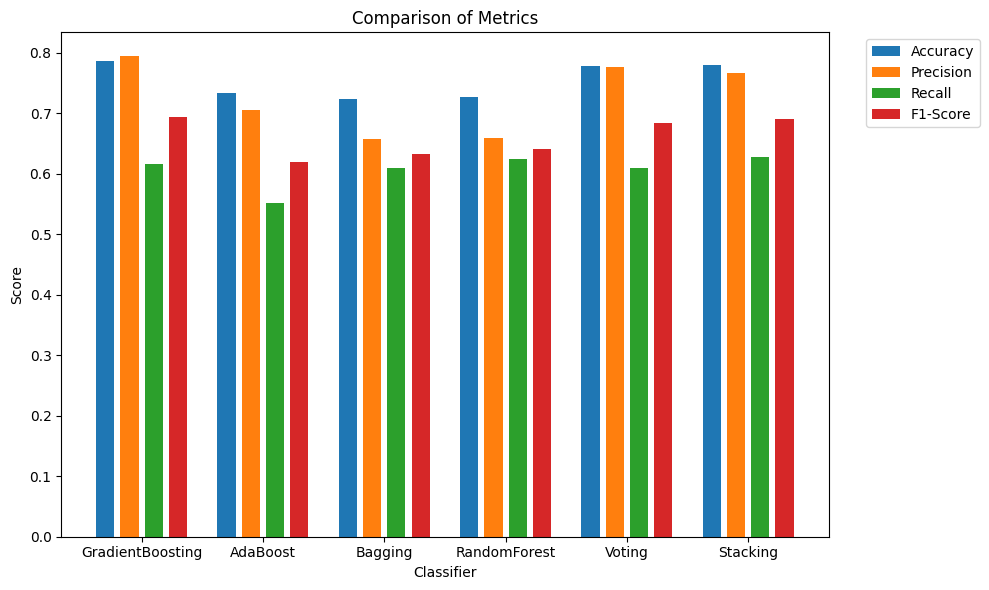

In [53]:

metrics = {
    'GradientBoosting': {
        'Accuracy': gb_accuracy,
        'Precision': gb_precision,
        'Recall': gb_recall,
        'F1-Score': gb_f1
    },

    'AdaBoost': {
        'Accuracy': ada_accuracy,
        'Precision': ada_precision,
        'Recall': ada_recall,
        'F1-Score': ada_f1
    },

    'Bagging': {
        'Accuracy': bagging_accuracy,
        'Precision': bagging_precision,
        'Recall': bagging_recall,
        'F1-Score': bagging_f1
    },

    'RandomForest': {
        'Accuracy': rf_accuracy,
        'Precision': rf_precision,
        'Recall': rf_recall,
        'F1-Score': rf_f1
    },

    'Voting': {
        'Accuracy': voting_accuracy,
        'Precision': voting_precision,
        'Recall': voting_recall,
        'F1-Score': voting_f1
    },

    'Stacking': {
        'Accuracy': stacking_accuracy,
        'Precision': stacking_precision,
        'Recall': stacking_recall,
        'F1-Score': stacking_f1
    }
}

visualize_metrics(metrics=metrics)


## Phần 3: Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán

### Feed Forward Neurl Network


Epoch 1/100
61/61 [==============================] - 2s 8ms/step - loss: 0.7833 - accuracy: 0.5993 - val_loss: 0.6819 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.6055 - val_loss: 0.6663 - val_accuracy: 0.6084
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6055 - val_loss: 0.6448 - val_accuracy: 0.6084
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6246 - val_loss: 0.6260 - val_accuracy: 0.7145
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.7435 - val_loss: 0.6231 - val_accuracy: 0.7265
Epoch 6/100
61/61 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.7539 - val_loss: 0.6078 - val_accuracy: 0.7313
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.7404 - val_loss: 0.6067 - val_accuracy: 0.7325
Epoch 8/100
6

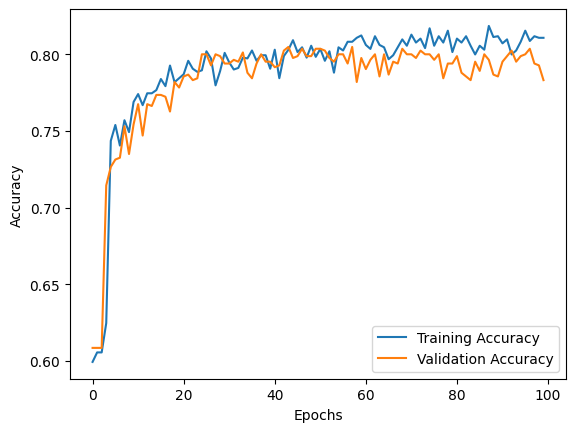

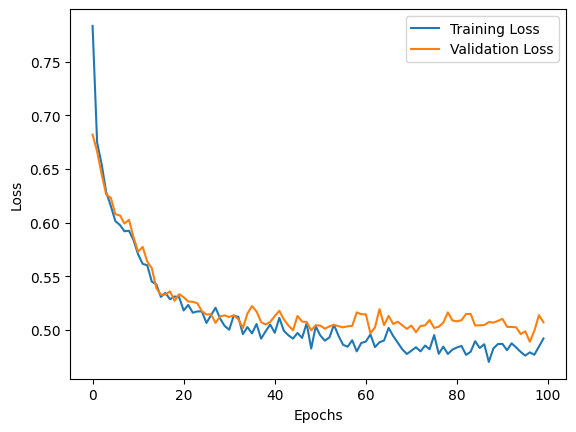

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [54]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(64, kernel_initializer='uniform', activation='relu', kernel_regularizer=regularizers.L1L2(0.01)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy', optimizer='adam')

history_FFNW = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

plot_accuracy_history(history_FFNW)
plot_loss_history(history_FFNW)

print(model_FFNW.summary())

In [55]:
print(model_FFNW.evaluate(X_test, y_test, verbose=0))

[0.5069963335990906, 0.7831325531005859]


### Reccurent Neural Network

In [56]:

model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 64, activation='relu', return_sequences=True, input_shape= (X_train.shape[1],1), dropout=0.25, kernel_regularizer=regularizers.L1(0.01)),
    tf.keras.layers.LSTM(units = 64, activation='relu', return_sequences=True,  dropout=0.25),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True,  dropout=0.25),
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid'),
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
61/61 [==============================] - 8s 42ms/step - loss: 0.7706 - accuracy: 0.5719 - val_loss: 0.7263 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 2s 33ms/step - loss: 0.7264 - accuracy: 0.6148 - val_loss: 0.6960 - val_accuracy: 0.6373
Epoch 3/100
61/61 [==============================] - 2s 32ms/step - loss: 0.6848 - accuracy: 0.6313 - val_loss: 0.6554 - val_accuracy: 0.6795
Epoch 4/100
61/61 [==============================] - 2s 40ms/step - loss: 0.6558 - accuracy: 0.6644 - val_loss: 0.6551 - val_accuracy: 0.6530
Epoch 5/100
61/61 [==============================] - 3s 44ms/step - loss: 0.6438 - accuracy: 0.6799 - val_loss: 0.6021 - val_accuracy: 0.7301
Epoch 6/100
61/61 [==============================] - 2s 31ms/step - loss: 0.6311 - accuracy: 0.6867 - val_loss: 0.6084 - val_accuracy: 0.7241
Epoch 7/100
61/61 [==============================] - 2s 33ms/step - loss: 0.6085 - accuracy: 0.7006 - val_loss: 0.6056 - val_accuracy: 0.7349
Epoch 

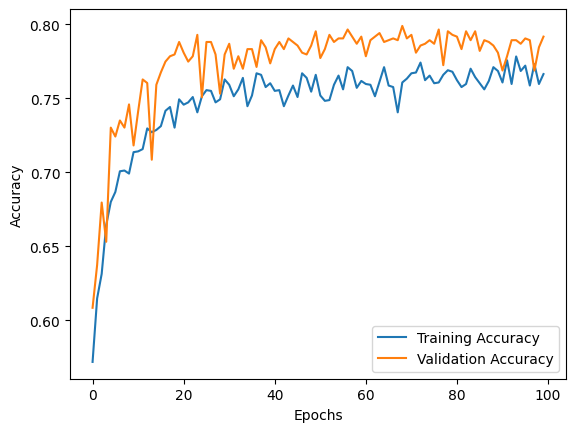

In [57]:
plot_accuracy_history(history_RNN)

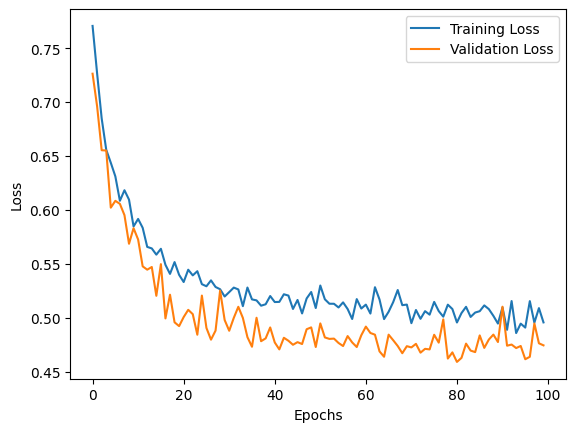

In [58]:
plot_loss_history(history_RNN)

In [59]:
print(model_RNN.evaluate(X_test, y_test, verbose=0))

[0.47443631291389465, 0.7915662527084351]


## Phần 4: Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán

### Các mô hình học máy cơ bản

### Ứng dụng các mô hình học máy thuộc Ensemble Learing

#### Gradient Boosting

In [62]:
gb_clf = GradientBoostingClassifier(max_depth=5, n_estimators=200, learning_rate=0.05)

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

gb_train_after = accuracy_score(y_train, y_train_pred)
gb_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(gb_train_before))
print("Test: {:.4f}".format(gb_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(gb_train_after))
print("Test: {:.4f}".format(gb_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.8294
Test: 0.7867

Accuracy sau khi áp dụng overfitting:
Train: 0.8661
Test: 0.7783


#### AdaBoost

In [63]:
base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_split=5)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=0.5)

ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_train_after = accuracy_score(y_train, y_train_pred)
ada_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(ada_train_before))
print("Test: {:.4f}".format(ada_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(ada_train_after))
print("Test: {:.4f}".format(ada_test_after))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy trước khi áp dụng overfitting:
Train: 0.7699
Test: 0.7337

Accuracy sau khi áp dụng overfitting:
Train: 0.8444
Test: 0.7855


#### Bagging

In [64]:
base_estimator = RandomForestClassifier(n_estimators=100)
bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=10)

bagging_clf.fit(X_train, y_train)
y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

bagging_train_after = accuracy_score(y_train, y_train_pred)
bagging_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(bagging_train_before))
print("Test: {:.4f}".format(bagging_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(bagging_train_after))
print("Test: {:.4f}".format(bagging_test_after))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy trước khi áp dụng overfitting:
Train: 0.9250
Test: 0.7229

Accuracy sau khi áp dụng overfitting:
Train: 0.9111
Test: 0.7566


#### Random Forest

In [65]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

rf_train_after = accuracy_score(y_train, y_train_pred)
rf_test_after = accuracy_score(y_test, y_test_pred)


print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(rf_train_before))
print("Test: {:.4f}".format(rf_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(rf_train_after))
print("Test: {:.4f}".format(rf_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.9374
Test: 0.7265

Accuracy sau khi áp dụng overfitting:
Train: 0.8077
Test: 0.7783


#### Voting Classifier

In [67]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1)
lr_clf = LogisticRegression(C=0.1)

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

voting_train_after = accuracy_score(y_train, y_train_pred)
voting_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(voting_train_before))
print("Test: {:.4f}".format(voting_test_before))

print("\nAccuracy sau khi áp dụng overfitting:")
print("Train: {:.4f}".format(voting_train_after))
print("Test: {:.4f}".format(voting_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.8485
Test: 0.7783

Accuracy sau khi áp dụng overfitting:
Train: 0.8102
Test: 0.7759


#### Stacking

In [68]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_features=3)),
    ('dt', DecisionTreeClassifier(max_depth=5))
]

lr_clf = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=lr_clf)

stacking_clf.fit(X_train, y_train)

y_train_pred = stacking_clf.predict(X_train)
y_test_pred = stacking_clf.predict(X_test)

stacking_train_after = accuracy_score(y_train, y_train_pred)
stacking_test_after = accuracy_score(y_test, y_test_pred)

print("Accuracy trước khi áp dụng overfitting:")
print("Train: {:.4f}".format(stacking_train_before))
print("Test: {:.4f}".format(stacking_test_before))

print("\nAccuracy sau khi áp dụng stacking:")
print("Train: {:.4f}".format(stacking_train_after))
print("Test: {:.4f}".format(stacking_test_after))

Accuracy trước khi áp dụng overfitting:
Train: 0.8268
Test: 0.7795

Accuracy sau khi áp dụng stacking:
Train: 0.8195
Test: 0.7783
